# Условие задачи, описание

# Импортирование библиотек, загрузка и анализ данных

Необходимо подготовить данные, для того чтобы их можно было использовать для обучения.

In [ ]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import catboost as cb
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import shuffle

import pickle
import time
from collections import Counter  
import gc
import math

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#import  pytorch_tabnet

In [ ]:
#from pytorch_tabnet.tab_model import TabNetClassifier
#from pytorch_tabnet.metrics import Metric

In [ ]:
data = pd.read_csv('train_dataset_train.csv', nrows = 2000000)

In [ ]:
nam = data.columns

In [ ]:
data.head()

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,...,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label
0,6818780,1043_-1,628629.0,Участок,7503.0,N,0.0,Y,N,87.0,...,42.0,720176.0,58950.0,779126.0,8290896.0,0,0,0,0,0
1,9907176,1023_-1,102976.0,ММПО,7503.0,N,0.0,N,N,107.0,...,914.0,48856658.0,83318932.0,132175590.0,136819803.0,0,0,0,0,0
2,3304275,1018_-1,620962.0,Цех,7503.0,N,0.0,Y,N,50.0,...,62.0,3246292.0,3233068.0,6479360.0,52708071.0,0,1,0,0,0
3,9020937,1019_-1,344964.0,Цех,7503.0,N,0.0,Y,N,416.0,...,55.0,2060928.0,653280.0,2714208.0,19562334.0,0,0,0,0,0
4,3082311,1020_-1,629819.0,Участок,7503.0,N,0.0,Y,N,795.0,...,16.0,316919.0,27911.0,344830.0,4719186.0,0,0,0,0,0


In [ ]:
data['oper_type + oper_attr'].unique()

array(['1043_-1', '1023_-1', '1018_-1', '1019_-1', '1020_-1', '1001_-1',
       '8_13', '1_-1', '1022_-1', '8_0', '8_3', '1041_-1', '1016_-1',
       '11_-1', '8_2', '8_6', '183_-1', '1042_-1', '9_-1', '1004_-1',
       '14_1', '1014_-1', '26_-1', '1044_-1', '29_-1', '0_-1', '184_-1',
       '185_-1', '39_-1', '2_1', '131_-1', '12_9', '41_-1', '2_6',
       '14_10', '12_1', '1026_-1', '1015_-1', '154_-1', '1025_-1',
       '1017_-1', '1012_-1', '8_5', '12_8', '8_4', '8_20', '1021_-1',
       '4_3', '14_1001', '14_18', '1027_-1', '6_3', '1017_1001', '114_-1',
       '1045_-1', '3_1', '14_21', '1017_1000', '30_-1', '1005_-1', '4_1',
       '184_1', '14_20', '8_182', '2_8', '11_0', '104_-1', '183_1',
       '41_4', '12_11', '20_-1', '15_-1', '41_1', '14_16', '12_2',
       '1013_-1', '12_10', '1002_-1', '3_9', '8_1', '12_4', '1003_-1',
       '2_10', '6_1', '4_2', '14_6', '14_17', '8_22', '2_11', '10_-1',
       '8_18', '41_3', '12_6', '3_10', '34_-1', '2_2'], dtype=object)

In [ ]:
data.groupby('oper_type + oper_attr')['label'].mean().sort_values().tail(13)

oper_type + oper_attr
12_6       0.000000
1043_-1    0.000129
1020_-1    0.000561
1044_-1    0.003799
41_-1      0.067073
1004_-1    0.357598
2_1        0.401691
2_6        0.455867
2_8        0.600000
8_182      0.816794
2_11       1.000000
2_2        1.000000
34_-1      1.000000
Name: label, dtype: float64

In [ ]:
data.groupby('oper_type + oper_attr')['label'].count().sort_values().tail(15)

oper_type + oper_attr
8_6         44747
1044_-1     44751
1043_-1     46476
8_2         47603
1023_-1     71759
1041_-1     96374
1042_-1     97998
1004_-1    103317
1018_-1    105612
1001_-1    117827
1_-1       119543
8_0        133878
1019_-1    138029
1022_-1    218709
1020_-1    231599
Name: label, dtype: int64

In [ ]:
max_label = data.groupby('oper_type + oper_attr')['label'].mean().sort_values().tail(13).index
max_label

Index(['12_6', '1043_-1', '1020_-1', '1044_-1', '41_-1', '1004_-1', '2_1',
       '2_6', '2_8', '8_182', '2_11', '2_2', '34_-1'],
      dtype='object', name='oper_type + oper_attr')

In [ ]:
max_ind = data.groupby('oper_type + oper_attr')['label'].count().sort_values().tail(15).index

max_ind

Index(['8_6', '1044_-1', '1043_-1', '8_2', '1023_-1', '1041_-1', '1042_-1',
       '1004_-1', '1018_-1', '1001_-1', '1_-1', '8_0', '1019_-1', '1022_-1',
       '1020_-1'],
      dtype='object', name='oper_type + oper_attr')

In [ ]:
data[data['oper_type + oper_attr'].isin(max_ind)].groupby('oper_type + oper_attr')['label'].mean().sort_values()

oper_type + oper_attr
1001_-1    0.000000
1018_-1    0.000000
1019_-1    0.000000
1022_-1    0.000000
1023_-1    0.000000
1041_-1    0.000000
1042_-1    0.000000
1_-1       0.000000
8_0        0.000000
8_2        0.000000
8_6        0.000000
1043_-1    0.000129
1020_-1    0.000561
1044_-1    0.003799
1004_-1    0.357598
Name: label, dtype: float64

In [ ]:
data.groupby('oper_type + oper_attr')['label'].count().sort_values().tail(15)

oper_type + oper_attr
8_6         44747
1044_-1     44751
1043_-1     46476
8_2         47603
1023_-1     71759
1041_-1     96374
1042_-1     97998
1004_-1    103317
1018_-1    105612
1001_-1    117827
1_-1       119543
8_0        133878
1019_-1    138029
1022_-1    218709
1020_-1    231599
Name: label, dtype: int64

In [ ]:
data['index_oper'].unique().size

29528

In [ ]:
data_v = pd.read_csv('test_dataset_test.csv')

In [ ]:
data_v.groupby('oper_type + oper_attr')['index_oper'].count().sort_values().tail(15)

oper_type + oper_attr
1044_-1     90070
8_6         90140
1043_-1     92805
8_2         95185
1023_-1    143417
1041_-1    192451
1042_-1    196258
1004_-1    205472
1018_-1    212302
1001_-1    236006
1_-1       240459
8_0        268559
1019_-1    276312
1022_-1    437702
1020_-1    461403
Name: index_oper, dtype: int64

In [ ]:
data['oper_type + oper_attr'].unique()

array(['1043_-1', '1023_-1', '1018_-1', '1019_-1', '1020_-1', '1001_-1',
       '8_13', '1_-1', '1022_-1', '8_0', '8_3', '1041_-1', '1016_-1',
       '11_-1', '8_2', '8_6', '183_-1', '1042_-1', '9_-1', '1004_-1',
       '14_1', '1014_-1', '26_-1', '1044_-1', '29_-1', '0_-1', '184_-1',
       '185_-1', '39_-1', '2_1', '131_-1', '12_9', '41_-1', '2_6',
       '14_10', '12_1', '1026_-1', '1015_-1', '154_-1', '1025_-1',
       '1017_-1', '1012_-1', '8_5', '12_8', '8_4', '8_20', '1021_-1',
       '4_3', '14_1001', '14_18', '1027_-1', '6_3', '1017_1001', '114_-1',
       '1045_-1', '3_1', '14_21', '1017_1000', '30_-1', '1005_-1', '4_1',
       '184_1', '14_20', '8_182', '2_8', '11_0', '104_-1', '183_1',
       '41_4', '12_11', '20_-1', '15_-1', '41_1', '14_16', '12_2',
       '1013_-1', '12_10', '1002_-1', '3_9', '8_1', '12_4', '1003_-1',
       '2_10', '6_1', '4_2', '14_6', '14_17', '8_22', '2_11', '10_-1',
       '8_18', '41_3', '12_6', '3_10', '34_-1', '2_2', '6_5', '5_3',
       '24_-1',

In [ ]:
data['class'].unique()

array([0., 3., 1., 2., 4., 5.])

In [ ]:
data['weight'].unique().size

2176

In [ ]:
data.loc[data['weight']==0, 'label'].sum(), data.loc[data['weight']==0, 'label'].count()

(3, 81)

In [ ]:
data.loc[data['weight_mfi']==0, 'label'].sum(), data.loc[data['weight_mfi']==0, 'label'].count()

(214, 13513)

In [ ]:
data['weight'] / data['weight_mfi']

0          2.121951
1          1.573529
2          0.892857
3         12.606061
4          1.110335
            ...    
499995     1.111765
499996     1.370370
499997     0.604167
499998          inf
499999     1.113636
Length: 500000, dtype: float64

In [ ]:
sorted(data['price_mfi'].unique())

[0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0,
 70.0,
 71.0,
 72.0,
 73.0,
 74.0,
 75.0,
 76.0,
 77.0,
 78.0,
 79.0,
 80.0,
 81.0,
 82.0,
 83.0,
 84.0,
 85.0,
 86.0,
 87.0,
 88.0,
 89.0,
 90.0,
 91.0,
 92.0,
 93.0,
 94.0,
 95.0,
 96.0,
 97.0,
 98.0,
 99.0,
 100.0,
 101.0,
 102.0,
 103.0,
 104.0,
 105.0,
 106.0,
 107.0,
 108.0,
 109.0,
 110.0,
 111.0,
 112.0,
 113.0,
 114.0,
 115.0,
 116.0,
 117.0,
 118.0,
 119.0,
 120.0,
 121.0,
 122.0,
 123.0,
 124.0,
 125.0,
 126.0,
 127.0,
 128.0,
 129.0,
 130.0,
 131.0,
 132.0,
 133.0,
 134.0,
 135.0,
 136.0,
 137.0,
 138.0

In [ ]:
data.loc[data['price_mfi']==0, 'label'].sum(), data.loc[data['price_mfi']==0, 'label'].count()

(214, 13518)

In [ ]:
data.loc[data['price_mfi']==0, 'label']

In [ ]:
data.loc[data['price_mfi']==0, ['price_mfi', 'weight', 'weight_mfi']]

,price_mfi,weight,weight_mfi
9,0.0,2201.0,0.0
11,0.0,846.0,0.0
15,0.0,134.0,0.0
46,0.0,934.0,0.0
67,0.0,180.0,0.0
...,...,...,...
99956,0.0,222.0,0.0
99959,0.0,656.0,0.0
99974,0.0,63.0,0.0
99979,0.0,866.0,0.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 29 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   id                             500000 non-null  int64  
 1   oper_type + oper_attr          500000 non-null  object 
 2   index_oper                     500000 non-null  object 
 3   type                           500000 non-null  object 
 4   priority                       500000 non-null  float64
 5   is_privatecategory             500000 non-null  object 
 6   class                          500000 non-null  float64
 7   is_in_yandex                   500000 non-null  object 
 8   is_return                      500000 non-null  object 
 9   weight                         500000 non-null  float64
 10  mailtype                       500000 non-null  float64
 11  mailctg                        500000 non-null  float64
 12  mailrank                      

In [ ]:
data['mailrank'].unique().size

1

In [ ]:
data['oper_type + oper_attr'].unique().size

73

<AxesSubplot:>

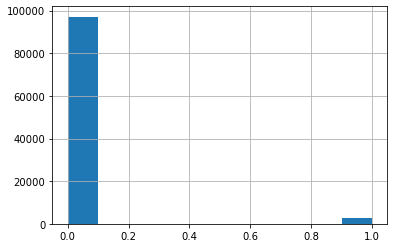

In [ ]:
data['label'].hist()

In [ ]:
data.head(3)

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,...,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label
0,6818780,1043_-1,628629.0,Участок,7503.0,N,0.0,Y,N,87.0,...,42.0,720176.0,58950.0,779126.0,8290896.0,0,0,0,0,0
1,9907176,1023_-1,102976.0,ММПО,7503.0,N,0.0,N,N,107.0,...,914.0,48856658.0,83318932.0,132175590.0,136819803.0,0,0,0,0,0
2,3304275,1018_-1,620962.0,Цех,7503.0,N,0.0,Y,N,50.0,...,62.0,3246292.0,3233068.0,6479360.0,52708071.0,0,1,0,0,0


In [ ]:
data['index_oper'] = data['index_oper'].astype(str)

In [ ]:
sorted(data['index_oper'].unique())

[' ',
 '0',
 '0.0',
 '101000',
 '102002',
 '102002.0',
 '102007',
 '102007.0',
 '102102',
 '102102.0',
 '102152',
 '102152.0',
 '102153',
 '102153.0',
 '102240',
 '102240.0',
 '102302',
 '102302.0',
 '102322',
 '102322.0',
 '102326',
 '102326.0',
 '102901.0',
 '102902',
 '102965.0',
 '102968',
 '102968.0',
 '102969',
 '102969.0',
 '102971',
 '102971.0',
 '102972',
 '102972.0',
 '102973',
 '102973.0',
 '102976',
 '102976.0',
 '102981',
 '102981.0',
 '102986',
 '102986.0',
 '102998',
 '102998.0',
 '104006',
 '104006.0',
 '104040',
 '104040.0',
 '105037',
 '105037.0',
 '105064.0',
 '105094.0',
 '105118',
 '105118.0',
 '105120.0',
 '105122',
 '105122.0',
 '105173.0',
 '105187',
 '105187.0',
 '105203',
 '105203.0',
 '105264.0',
 '105275.0',
 '105318',
 '105425',
 '105425.0',
 '105484.0',
 '105523',
 '105554',
 '105554.0',
 '105568',
 '105568.0',
 '107014.0',
 '107023',
 '107023.0',
 '107065',
 '107076',
 '107076.0',
 '107113.0',
 '107140.0',
 '107143',
 '107143.0',
 '107150.0',
 '107207.0',

## Вывод

Данные характеризуются довольно сильным дисбалансом классов. При этом в данных есть ряд категориальных переменных из которых столбец **oper_type + oper_attr** очень сильно влияет на классы. Есть два варианта - исключить этот столбец полностью или разбить данные по этому столбцу и строить для каждой подгруппы отдельные модели.

# Предобработка данных

In [ ]:
del data
del dat
gc.collect()

16672

In [ ]:
def is_cat(data):
    for i in data.dtypes[(data.dtypes == 'category') + (data.dtypes =='object')].index:
        data[i] = pd.Categorical(data[i])
        data[i].astype('category').cat.codes
        data[i] = data[i].cat.codes
    return data

In [ ]:
nam_dict = {'case' : 1, 'protector': 2, 'necklac': 3, 'ring':3, 'earr': 3, 
            'cable':4, 'glass':5, 'sticker':5, 'panties':6, 'car': 7, 'decor':8, 'sock':6, 'bra':6,
            'beads':3, 'circuit':9, 'bracelet':3, 
           't-shirts':10, 'fishing':11, 'bumper':12, 'earphon':13, 'adapter':14, 'dress':6, 'toy':15,
            'electronic':16, 'underwear':6, 'strap':17, 
           'hat':6, 'connector':14, 'brooch':3, 'stationer':18, 'jewelry':3, 'charger':19, 'pen':18,
            'phone':20, 'hair':21, 
            'accum':19, 'part':22, 'cool':23, 'bag':24, 'accessor':25, 'baby':26, 'beanie':6, 'carnival':27, 
            'case':2, 'cover':2, 'decoration':28, 'furnish':28, 'tool':29, 'hat':6, 'holiday':27, 'laptop':30,
            'lead':4,
            'kid':12, 'mat':31, 'mounting':32, 'offic':33, 'ornament':28, 'sleev':34, 'plush':35, 'joke':23,
            'rack':16, 'relay':16, 
            'yoga':36, 'xiaomi':20, 'bluetoo':39, 'ящик':32, 'электр':16, 'фен':37, 'сумка':24, 'спорт':36, 'смарт':20,
            'очки':5, 'светод':38, 'рыб':11, 'рамка':12, 'наушн':13, 'носк':6, 'нож':40, 'кабель':4, 'набор':41,
            'мыш':42, 'магнит':43, 'кух':44, 'женск':45, 'детс':26, 'автомоб':7, "кольц":3, "бусы":3}

In [ ]:
def prepr_1(data):
    data['oper_attr'] = data['oper_type + oper_attr'].str.extract('_(.+)').astype(int)
    data['oper_type'] = data['oper_type + oper_attr'].str.extract('(.+)_').astype(int)
    data['oper_code'] = data['oper_type'] + data['oper_attr']
    data['t'] = data['total_qty_over_index'].apply(math.tan) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    data['error_sum'] = (data['is_wrong_sndr_name'] + data['is_wrong_rcpn_name'] 
                         + data['is_wrong_phone_number'] + data['is_wrong_address'])
    data['mfi_cat'] = 0
    data.loc[data['name_mfi'].str.count(r'[\u2E80-\u9FFF]') > 0, 'mfi_cat'] = 50
    for nam in nam_dict:
        data.loc[data['name_mfi'].str.contains(nam, case=False), 'mfi_cat'] = nam_dict[nam]
    data['name_mfi_num'] = data['name_mfi'].str.count(',') + 1
    data = data.drop(columns = ['name_mfi', 'mailrank', 'oper_type + oper_attr', 'oper_attr', 'oper_type'])
    data['index_oper'] = data['index_oper'].astype(str)
    data.loc[data['index_oper'] == ' ', 'index_oper'] = 0
    data['index_oper'] = data['index_oper'].astype(float)
    data['price_per_gram'] = (data['price_mfi']) /(data['weight'] +1)
    data['price_per_num'] = (data['price_mfi']) /data['name_mfi_num']
    return data

In [ ]:
dat = pd.read_csv('train_dataset_train.csv', nrows = 2000000)
nam = dat.columns
dat_t = pd.read_csv('train_dataset_train.csv', names = nam ,  skiprows = 2000000, nrows = 2000000)

In [ ]:
data = prepr_1(dat)
data_t = prepr_1(dat_t)

In [ ]:
col_drop_1 = ['type',
 'oper_type + oper_attr']

In [ ]:
data = data.drop(columns = col_drop_1)

data_t = data_t.drop(columns = col_drop_1)

In [ ]:
data = is_cat(data)
data_t = is_cat(data_t)

In [ ]:
features_train = data.drop(columns = ['id', 'label']).sample(frac=1, random_state=123)
target_train = data['label'].sample(frac=1, random_state=123)
features_test, features_1, target_test, target_1 = train_test_split(data_t.drop(columns = ['id', 'label']), 
                                                                              data_t['label'], test_size=0.3, random_state=123)

In [ ]:
data_valid = pd.read_csv('test_dataset_test.csv')
data_val = prepr_1(data_valid).drop(columns = col_drop_1)
data_val = is_cat(data_val)


## Вывод:

Создал функции для обработки данных (разными способами) и перевода категориальных данных в численные.
Разделил данные на тестовую и тренировочную часть.

# Обучение

## Обучение случайным лесом

In [ ]:
r_f_c_1 = RandomForestClassifier(random_state = 123) #, class_weight='balanced', n_jobs = 3)
r_f_c_1.fit(features_train, target_train)

RandomForestClassifier(random_state=123)

In [ ]:
metric_r_f_c_1 = (
    0.1 * recall_score(target_test, r_f_c_1.predict(features_test), average='macro', pos_label = 0) +
    roc_auc_score(target_test,  r_f_c_1.predict(features_test), average='macro', multi_class = 'ovo') * 0.9
)
print('metric_mod', 
      metric_r_f_c_1, 
      'f1_mod', 
      f1_score(target_test,  r_f_c_1.predict(features_test), average='macro'))

metric_mod 0.85809732775795 f1_mod 0.587708626740366


In [ ]:
вввв

In [ ]:
pred_r_f_c_1 = r_f_c_1.predict(data_val.drop(columns = 'id'))                   
out_r_f_c_1 = pd.DataFrame(pred_r_f_c_1, columns=['label'])
out_r_f_c_1['id'] = data_val['id']
out_r_f_c_1 = out_r_f_c_1.reindex(columns=['id', 'label'])
out_r_f_c_1.to_csv('200_out_rfc_1_balanc.csv', line_terminator = '\n', index=False)

In [ ]:
r_f_c = RandomForestClassifier(random_state = 123,  class_weight='balanced', n_jobs = -1)
parametrs = { 'max_depth': [3, 4, 5, 6],
              'criterion' : ['gini', 'entropy'],
              'n_estimators': [60, 100, 120],
              'min_samples_leaf': [2, 3, 4, 5],
              'min_samples_split': [2, 3, 4, 5],
            }
grid_r_f_c = GridSearchCV(r_f_c, parametrs, cv=4, scoring = 'f1')
grid_r_f_c.fit(features_train.drop(columns = cat), target_train)

In [ ]:
grid_r_f_c.best_score_

In [ ]:
grid_r_f_c.best_params_

In [ ]:
metric_rfc_gr = (0.1 * recall_score(target_test, grid_r_f_c.predict(features_test.drop(columns = cat))) + roc_auc_score(target_test, grid_r_f_c.predict(features_test.drop(columns = cat))) * 0.9)
metric_rfc_gr

## Катбуст

In [ ]:
y_train = np.array(target_train)
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

{0: 0.5146317526762137, 1: 17.58612806218455}

In [ ]:
ti_3 = time.perf_counter()
params = {'depth': [3, 4, 6, 7, 8, 9],
          'learning_rate' : [0.01, 0.02, 0.03, 0.5],
         'l2_leaf_reg': [2, 3, 4, 5, 6, 7, 8, 9],
         'iterations': [220],
         'bootstrap_type':['No', 'Bayesian', 'Bernoulli', 'MVS']}
cb_c = cb.CatBoostClassifier(loss_function = 'Logloss', eval_metric='AUC', verbose=False,  
                             random_state = 123, class_weights = class_weights, thread_count = 4) #, task_type="GPU")
cb_bayes = RandomizedSearchCV(cb_c, params, scoring="recall_macro",  cv = 3, n_iter= 70)
cb_bayes.fit(features_train, target_train, eval_set=(features_1, target_1))
time_cb = (time.perf_counter() - ti_3) / 60
print(f'время работы CatBoost:  {time_cb} мин')

время работы CatBoost:  18.084962320783333 мин


In [ ]:
cb_bayes.best_params_

{'learning_rate': 0.5,
 'l2_leaf_reg': 6,
 'iterations': 220,
 'depth': 9,
 'bootstrap_type': 'No'}

In [ ]:
print('recall_grid', 
      recall_score(target_test, cb_bayes.predict(features_test), average='macro'), 
      'f1_grid', 
      f1_score(target_test, cb_bayes.predict(features_test), average='macro'))

NameError: name 'cb_bayes' is not defined

In [ ]:
ti_3 = time.perf_counter()
cb_mod = cb.CatBoostClassifier(loss_function = 'Logloss', eval_metric='TotalF1',
                               verbose=False, thread_count = 3, iterations = 1900, early_stopping_rounds=170,
                               random_state = 123, l2_leaf_reg = 2, learning_rate = 0.02,
                               depth= 7, class_weights = class_weights, task_type="GPU") #, cat_features = ca)
cb_mod.fit(features_train, target_train, plot=True, eval_set=(features_1, target_1))
time_cb = (time.perf_counter() - ti_3) / 60
print(f'время работы CatBoost:  {time_cb} мин')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

время работы CatBoost:  1.2777028427333335 мин


In [ ]:
ti_3 = time.perf_counter()
cb_mod = cb.CatBoostClassifier(loss_function = 'Logloss',
                               verbose=False, thread_count = 3, iterations = 1200, 
                               random_state = 123, l2_leaf_reg = 2, learning_rate = 0.03,
                               depth= 7, class_weights = class_weights) #, task_type="GPU")
cb_mod.fit(features_train, target_train)
time_cb = (time.perf_counter() - ti_3) / 60
print(f'время работы CatBoost:  {time_cb} мин')

время работы CatBoost:  4.647502543116661 мин


In [ ]:
roc_auc_score(target_test, cb_mod.predict(features_test))

0.8807145434259909

In [ ]:
0.8679264709412975

In [ ]:
pred_cb = cb_mod.predict_proba(features_test)

In [ ]:
print('recall_grid', 
      recall_score(target_test, cb_mod.predict(features_test), average='macro'), 
      'f1_grid', 
      f1_score(target_test, cb_mod.predict(features_test), average='macro'))

recall_grid 0.9749696273659514 f1_grid 0.7698225304048099


<AxesSubplot:ylabel='feature_names'>

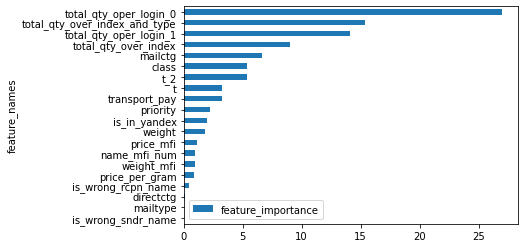

In [ ]:
data = pd.DataFrame({'feature_importance': cb_mod.get_feature_importance(), 
              'feature_names': features_train.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False)
data[:20].sort_values(by=['feature_importance'], ascending=True).plot.barh(x='feature_names', y='feature_importance')

## LGBMClassifier

In [ ]:
params = {'max_depth': [3, 4, 5, 6, 7, 8, 10, 12, 15, 18, 20, 25, 30, 35, 40],
          'learning_rate' : [0.01, 0.05, 0.1, 0.15],
         'lambda_l2': [0, 7, 10, 12, 15, 20, 30, 35],
         'feature_fraction': [0.6, 0.7, 0.8, 0.9, 0.95, 0.99],
          'n_estimators' : [80, 100, 120, 150, 300, 350],
          'bagging_fraction': [0.6, 0.7, 0.8, 0.9, 0.95, 0.99],
         'cat_smooth': [1, 3, 5, 8, 10, 13, 15, 20, 35]}

lgb = LGBMClassifier(random_state = 123, verbose_eval = False, class_weight='balanced', thread_count = 4)
lgb_bayes = RandomizedSearchCV(lgb, params, scoring="recall_macro", cv = 3, n_iter = 20)
lgb_bayes.fit(features_train, target_train)


[LightGBM] [Warning] Unknown parameter: thread_count
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.99, subsample=1.0 will be ignored. Current value: bagging_fraction=0.99
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] Unknown parameter: thread_count
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.99, subsample=1.0 will be ignored. Current value: bagging_fraction=0.99
[LightGBM] [Warning] lambda_l2 is set=35, reg_lambda=0.0 will be ignored. Current value: lambda_l2=35
[LightGBM] [Warning] Unknown parameter: thread_count
[LightGBM] [Warning] Unknown parameter: verbo

RandomizedSearchCV(cv=3,
                   estimator=LGBMClassifier(class_weight='balanced',
                                            random_state=123, thread_count=4,
                                            verbose_eval=False),
                   n_iter=20,
                   param_distributions={'bagging_fraction': [0.6, 0.7, 0.8, 0.9,
                                                             0.95, 0.99],
                                        'cat_smooth': [1, 3, 5, 8, 10, 13, 15,
                                                       20, 35],
                                        'feature_fraction': [0.6, 0.7, 0.8, 0.9,
                                                             0.95, 0.99],
                                        'lambda_l2': [0, 7, 10, 12, 15, 20, 30,
                                                      35],
                                        'learning_rate': [0.01, 0.05, 0.1,
                                                          0.15],
 

In [ ]:
lgb_bayes.best_params_

{'n_estimators': 100,
 'max_depth': 18,
 'learning_rate': 0.1,
 'lambda_l2': 10,
 'feature_fraction': 0.8,
 'cat_smooth': 13,
 'bagging_fraction': 0.8}

In [ ]:
lgb_bayes.best_score_

0.8834301056950261

In [ ]:
metric_lgb_bayes = (
    0.1 * recall_score(target_test, lgb_bayes.predict(features_test), average='macro', pos_label = 0) +
    roc_auc_score(target_test, lgb_bayes.predict(features_test), average='macro', multi_class = 'ovo') * 0.9
)
print('metric_lgb_bayes', 
      metric_lgb_bayes, 
      'f1_lgb_bayes', 
      f1_score(target_test, lgb_bayes.predict(features_test), average='macro'))

metric_lgb_bayes 0.8812165444934632 f1_lgb_bayes 0.5675489287198974


In [ ]:
metric_lgb_bayes = (
    0.1 * recall_score(data_test['label'], lgb_1.predict(data_test.drop(columns = 'label')), average='macro') +
    roc_auc_score(data_test['label'], lgb_1.predict(data_test.drop(columns = 'label')), average='macro', multi_class = 'ovo') * 0.9
)
print('metric_lgb_bayes', 
      metric_lgb_bayes, 
      'f1_lgb_bayes', 
      f1_score(data_test['label'], lgb_1.predict(data_test.drop(columns = 'label')), average='macro'))

metric_lgb_bayes 0.9763978958399928 f1_lgb_bayes 0.7684648617926425


In [ ]:
pred_lgb_1 = lgb_1.predict(data_val.drop(columns = 'id'))
out_lgb_1 = pd.DataFrame(pred_lgb_1, columns=['label'])
out_lgb_1['id'] = data_val['id']
out_lgb_1 = out_lgb_1.reindex(columns=['id', 'label'])
out_lgb_1.to_csv('30_out_lgb_1.csv', line_terminator = '\n', index=False)

#  Создание фичей перебором

In [ ]:
lgb_sel = LGBMClassifier(random_state = 123, n_estimators = 120, verbose_eval = False, class_weight='balanced')
lgb_sel.fit(features_train, target_train)
metric_lgb_sel = (0.1 * recall_score(target_test, lgb_sel.predict(features_test), average='macro') +
                  roc_auc_score(target_test, lgb_sel.predict(features_test), average='macro') * 0.9)
metric_lgb_sel

[LightGBM] [Warning] Unknown parameter: verbose_eval


0.8824820224976488

In [ ]:
ou_2 = []
lgb_sel = LGBMClassifier(random_state = 123, verbose_eval = False, class_weight='balanced')
lgb_sel.fit(features_train.drop(columns = 'oper_code'), target_train)
print(f1_score(target_test, lgb_sel.predict(features_test.drop(columns = 'oper_code')), average='macro'))
for i in data_t['oper_code'].unique():
    features_test_1 = data_t[data_t['oper_code'] == i].drop(columns = ['id', 'label', 'oper_code'])
    target_test_1 = data_t.loc[data_t['oper_code'] == i, 'label']
    metric_lgb_sel = (
        f1_score(target_test_1, lgb_sel.predict(features_test_1), average='macro'))
    ou_2.append([target_test_1.count(), metric_lgb_sel, i])


NameError: name 'features_train' is not defined

In [ ]:
sorted(ou_2)

[[1, 0.0, 35],
 [1, 0.0, 38],
 [1, 0.0, 101],
 [1, 0.0, 138],
 [1, 0.0, 208],
 [1, 0.0, 538],
 [1, 1.0, 25],
 [1, 1.0, 76],
 [1, 1.0, 248],
 [2, 0.3333333333333333, 72],
 [2, 1.0, 178],
 [3, 0.0, 123],
 [3, 1.0, 30],
 [4, 0.0, 132],
 [4, 0.0, 142],
 [4, 0.2, 71],
 [4, 1.0, 224],
 [5, 0.16666666666666669, 91],
 [5, 0.37499999999999994, 1013],
 [8, 0.4666666666666667, 1012],
 [8, 1.0, 1023],
 [9, 0.0, 113],
 [9, 0.6493506493506493, 102],
 [11, 0.15384615384615385, 34],
 [16, 0.1111111111111111, 52],
 [23, 1.0, 1015],
 [46, 0.4945054945054945, 114],
 [96, 0.04950495049504951, 33],
 [104, 0.045871559633027525, 31],
 [105, 0.08695652173913042, 213],
 [108, 0.0, 40],
 [114, 0.42131979695431476, 1848],
 [128, 0.09219858156028368, 56],
 [138, 1.0, 1055],
 [159, 0.45918367346938777, 234],
 [162, 1.0, 124],
 [167, 0.06179775280898877, 112],
 [174, 0.4897360703812317, 1022],
 [228, 0.46728971962616817, 244],
 [235, 0.49786324786324787, 1025],
 [313, 0.06355365402877478, 51],
 [341, 0.491803278688

In [ ]:
ou_3 = []
for i in data_t['oper_code'].unique():
    try:
        features_train_2, features_test_2, target_train_2, target_test_2 = train_test_split(data_t[data_t['oper_code'] == i].drop(columns = ['id', 'label', 'oper_code']),
                                                                                             data_t.loc[data_t['oper_code'] == i, 'label'], test_size=0.3, random_state=123)
        lgb_sel = LGBMClassifier(random_state = 123, verbose_eval = False, class_weight='balanced')
        lgb_sel.fit(features_train_2, target_train_2)
        metric_lgb_sel = (
        f1_score(target_test_2, lgb_sel.predict(features_test_2), average='macro')  )
        ou_3.append([target_test_2.count(), metric_lgb_sel, i])
    except:
        print(i)

[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbos

In [ ]:
sorted(ou_3)

[[1, 1.0, 30],
 [1, 1.0, 72],
 [1, 1.0, 123],
 [1, 1.0, 178],
 [2, 0.3333333333333333, 71],
 [2, 1.0, 91],
 [2, 1.0, 132],
 [2, 1.0, 142],
 [2, 1.0, 224],
 [2, 1.0, 1013],
 [3, 0.25, 102],
 [3, 1.0, 113],
 [3, 1.0, 1012],
 [3, 1.0, 1023],
 [4, 1.0, 34],
 [5, 1.0, 52],
 [7, 1.0, 1015],
 [14, 1.0, 114],
 [29, 1.0, 33],
 [32, 1.0, 31],
 [32, 1.0, 213],
 [33, 1.0, 40],
 [35, 0.42721791559000866, 1848],
 [39, 1.0, 56],
 [42, 1.0, 1055],
 [48, 1.0, 234],
 [49, 1.0, 124],
 [51, 1.0, 112],
 [53, 1.0, 1022],
 [69, 1.0, 244],
 [71, 1.0, 1025],
 [94, 0.5290944123314066, 51],
 [103, 1.0, 164],
 [139, 1.0, 11037],
 [145, 1.0, 214],
 [160, 1.0, 122],
 [185, 1.0, 228],
 [204, 1.0, 1027],
 [212, 1.0, 54],
 [230, 1.0, 11047],
 [245, 1.0, 10044],
 [264, 1.0, 1031],
 [336, 1.0, 1035],
 [358, 1.0, 68],
 [418, 1.0, 36],
 [462, 1.0, 1037],
 [532, 1.0, 42],
 [656, 1.0, 141],
 [834, 1.0, 78],
 [979, 1.0, 134],
 [2167, 1.0, 1036],
 [2314, 0.6928452546127257, 82],
 [4090, 1.0, 39],
 [5710, 1.0, 193],
 [5741, 1.

In [ ]:
oper_code_b_bed = [1032, 1029, 1028, 1014, 1052, 1051, 48, 1054, 32, 1024, 44, 82, 68, 51, 112, 1848]
# Обучение на полном наборе данных с меткой oper_code с точностью менее 0,83 (0.5)
oper_code_sort_bed = [1014, 1054, 32, 82, 51, 1848]
#[30803, 0.7855917762251445, 1014],
#[13449, 0.5351025775001292, 1054]
#[11775, 0.6735607133615883, 32]
#[2314, 0.6918857927786499, 82],
#[94, 0.5378787878787878, 51]
#[35, 0.44, 1848]
oper_code_sort_cool = [1032, 1029, 1028, 1052, 1051, 48, 1024, 44, 68, 112]

In [ ]:
oper_code_b_cool = [1030, 28, 11, 1011, 1033, 88, 58, 1026, 21, 19, 158, 10, 195, 194, 49, 193, 39,
                   1036, 134, 78, 141, 42, 1037, 36, 1035]

In [ ]:
ou_4 = []
features_train_b = data[data['oper_code'].isin(oper_code_sort_bed)].drop(columns = ['id', 'label', 'oper_code']).sample(frac=1, random_state=123)
target_train_b = data.loc[data['oper_code'].isin(oper_code_sort_bed), 'label'].sample(frac=1, random_state=123)
lgb_sel = LGBMClassifier(random_state = 123, verbose_eval = False, class_weight='balanced')
lgb_sel.fit(features_train_b, target_train_b)
for i in oper_code_sort_bed:    
    features_test_2 = data_t[data_t['oper_code'] == i].drop(columns = ['id', 'label', 'oper_code'])
    target_test_2 = data_t.loc[data_t['oper_code'] == i, 'label']
    metric_lgb_sel = (
        f1_score(target_test_2, lgb_sel.predict(features_test_2), average='macro'))
    ou_4.append([target_test_2.count(), metric_lgb_sel, i])

[LightGBM] [Warning] Unknown parameter: verbose_eval


In [ ]:
sorted(ou_4)

[[114, 0.42131979695431476, 1848],
 [313, 0.5139751552795031, 51],
 [7712, 0.4584233266639538, 82],
 [39250, 0.5301801811590048, 32],
 [44829, 0.49896616856481846, 1054],
 [102675, 0.7726494723944461, 1014]]

In [ ]:
features_train_b2 = data[data['oper_code'].isin(oper_code_sort_cool)].drop(columns = ['id', 'label', 'oper_code']).sample(frac=1, random_state=123)
target_train_b2 = data.loc[data['oper_code'].isin(oper_code_sort_cool), 'label'].sample(frac=1, random_state=123)

features_test_22 = data_t[data_t['oper_code'].isin(oper_code_sort_cool)].drop(columns = ['id', 'label', 'oper_code']).sample(frac=1, random_state=123)
target_test_22 = data_t.loc[data_t['oper_code'].isin(oper_code_sort_cool), 'label'].sample(frac=1, random_state=123)
lgb_sel = LGBMClassifier(random_state = 123, verbose_eval = False, class_weight='balanced')
lgb_sel.fit(features_train_b2, target_train_b2)

print(f1_score(target_test_22, lgb_sel.predict(features_test_22), average='macro'))


[LightGBM] [Warning] Unknown parameter: verbose_eval
1.0


In [ ]:
features_train_b5 = data.drop(columns = ['id', 'label']).sample(frac=1, random_state=123)
target_train_b5 = data['label'].sample(frac=1, random_state=123)

features_test_25 = data_t[data_t['oper_code'].isin(oper_code_b_cool)].drop(columns = ['id', 'label']).sample(frac=1, random_state=123)
target_test_25 = data_t.loc[data_t['oper_code'].isin(oper_code_b_cool), 'label'].sample(frac=1, random_state=123)
lgb_sel = LGBMClassifier(random_state = 123, verbose_eval = False, class_weight='balanced')
lgb_sel.fit(features_train_b5, target_train_b5)

print(f1_score(target_test_25, lgb_sel.predict(features_test_25), average='macro'))

[LightGBM] [Warning] Unknown parameter: verbose_eval
0.6710418891675072


In [ ]:
data.loc[data['oper_code'].isin(oper_code_sort_bed), 'label'].count() / data['label'].count()

0.0979865

In [ ]:
data['label'].count()

2000000

In [ ]:
oper_code_b_cool = [1030, 28, 11, 1011, 1033, 88, 58, 1026, 21, 19, 158, 10, 195, 194, 49, 193, 39,
                   1036, 134, 78, 141, 42, 1037, 36, 1035]
# Обрабатывать на полном наборе данных одной группой с сохранением столбца oper_code

In [ ]:
oper_code_sort_cool = [1032, 1029, 1028, 1052, 1051, 48, 1024, 44, 68, 112]

# Обрабатывать на этом же наборе одной группой без столбца oper_code

In [ ]:
oper_code_sort_bed = [1014, 1054, 32, 82, 51, 1848]

# Обрабатывать на раздельных наборах данных 
# самое низкое качество 0.0979865 от всего числа значений точность примерно 0.7

# РАСЧЁТ ПО ЧАСТЯМ

In [ ]:
dat = pd.read_csv('train_dataset_train.csv', nrows = 100)
nam = dat.columns
data_valid = pd.read_csv('train_dataset_train.csv', names = nam ,  skiprows = 4000000, nrows = 1000000)
data_val = prepr_1(data_valid)
data_val = is_cat(data_val)

In [ ]:
data_val_val = data_val[['id', 'label']]
data_val_zzz = data_val.copy()
data_val = data_val.drop(columns = 'label')

In [ ]:
data_big_index = data_val.loc[data_val['oper_code'].isin(oper_code_b_cool), 'id']

In [ ]:
data_sort_index =  data_val.loc[data_val['oper_code'].isin(oper_code_sort_cool), 'id'] 

In [ ]:
data_bed_index =  data_val.loc[data_val['oper_code'].isin(oper_code_sort_bed), 'id'] 

In [ ]:
data_out_index =  data_val.loc[~data_val['oper_code'].isin(oper_code_max), 'id'] 

In [ ]:
data_all_index = data_val['id'] 

In [ ]:
oper_code_b_cool = [1030, 28, 11, 1011, 1033, 88, 58, 1026, 21, 19, 158, 10, 195, 194, 49, 193, 39,
                   1036, 134, 78, 141, 42, 1037, 36, 1035]
# Обрабатывать на полном наборе данных одной группой с сохранением столбца oper_code

oper_code_sort_cool = [1032, 1029, 1028, 1052, 1051, 48, 1024, 44, 68, 112]
# Обрабатывать на этом же наборе одной группой без столбца oper_code

oper_code_sort_bed = [1014, 1054, 32, 82, 51, 1848]
# Обрабатывать на раздельных наборах данных 
# самое низкое качество 0.0979865 от всего числа значений точность примерно 0.7

oper_code_max = oper_code_b_cool + oper_code_sort_cool + oper_code_sort_bed 

In [ ]:
def prepr_1(data):
    data['oper_attr'] = data['oper_type + oper_attr'].str.extract('_(.+)').astype(int)
    data['oper_type'] = data['oper_type + oper_attr'].str.extract('(.+)_').astype(int)
    data['oper_code'] = data['oper_type'] + ((data['oper_attr'] + 2) * 10)
    data['t_total_qty_over_index'] = data['total_qty_over_index'].apply(math.tan) 
    data['t_total_qty_oper_login_1'] = data['total_qty_oper_login_1'].apply(math.tan) 
    data['t_transport_pay'] = data['transport_pay'].apply(math.tan) 
    data['t_class'] = data['class'].apply(math.tan) 
    data['error_sum'] = (data['is_wrong_sndr_name'] + data['is_wrong_rcpn_name'] 
                         + data['is_wrong_phone_number'] + data['is_wrong_address'])
    data['name_mfi_num'] = data['name_mfi'].str.count(',') + 1
    data['index_oper'] = data['index_oper'].astype(str)
    data.loc[data['index_oper'] == ' ', 'index_oper'] = 0
    data['index_oper'] = data['index_oper'].astype(float)
    data['price_per_gram'] = (data['price_mfi']) /(data['weight'] +1)
    data['price_per_num'] = (data['price_mfi']) /data['name_mfi_num']
    return data.drop(columns = ['name_mfi', 'mailrank', 'oper_type + oper_attr', 'oper_attr', 'oper_type'])

In [ ]:
def is_cat(data):
    for i in data.dtypes[(data.dtypes == 'category') + (data.dtypes =='object')].index:
        data[i] = pd.Categorical(data[i])
        data[i].astype('category').cat.codes
        data[i] = data[i].cat.codes
    return data

In [ ]:
dat = pd.read_csv('train_dataset_train.csv', nrows = 3000000)
data = prepr_1(dat)
data = is_cat(data)

In [ ]:
data_valid = pd.read_csv('test_dataset_test.csv')
data_val = prepr_1(data_valid)
data_val = is_cat(data_val)

In [ ]:
lgb_b_cool = LGBMClassifier(random_state = 123, verbose_eval = False, class_weight='balanced')
lgb_b_cool.fit(data.drop(columns = ['id', 'label']), data['label'])

[LightGBM] [Warning] Unknown parameter: verbose_eval


LGBMClassifier(class_weight='balanced', random_state=123, verbose_eval=False)

In [ ]:
pred_b_cool = pd.DataFrame(lgb_b_cool.predict(data_val[data_val['oper_code'].isin(oper_code_b_cool)].drop(columns = 'id')), 
                           index = data_val.loc[data_val['oper_code'].isin(oper_code_b_cool), 'id'], columns=['label'])

In [ ]:
lgb_sort_cool = LGBMClassifier(random_state = 123, verbose_eval = False, class_weight='balanced')
lgb_sort_cool.fit(
    data[data['oper_code'].isin(oper_code_sort_cool)].drop(columns = ['id', 'label', 'oper_code']).sample(frac=1, random_state=123), 
    data.loc[data['oper_code'].isin(oper_code_sort_cool), 'label'].sample(frac=1, random_state=123))

[LightGBM] [Warning] Unknown parameter: verbose_eval


LGBMClassifier(class_weight='balanced', random_state=123, verbose_eval=False)

In [ ]:
pred_sort_cool = pd.DataFrame(lgb_sort_cool.predict(data_val[data_val['oper_code'].isin(oper_code_sort_cool)].drop(columns = ['id', 'oper_code'])), 
                           index = data_val.loc[data_val['oper_code'].isin(oper_code_sort_cool), 'id'], columns=['label'])

In [ ]:
rez_bed = []
for i in oper_code_sort_bed:
    lgb_sort_bed = LGBMClassifier(random_state = 123, verbose_eval = False, class_weight='balanced')
    lgb_sort_bed.fit(
        data[data['oper_code']==i].drop(columns = ['id', 'label']).sample(frac=1, random_state=123), 
        data.loc[data['oper_code']==i, 'label'].sample(frac=1, random_state=123))
    pred_sort_bed = pd.DataFrame(lgb_sort_bed.predict(data_val[data_val['oper_code']==i].drop(columns = ['id'])), 
                                 index = data_val.loc[data_val['oper_code']==i, 'id'], columns=['label'])
    rez_bed.append(pred_sort_bed)

[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval
[LightGBM] [Warning] Unknown parameter: verbose_eval


In [ ]:
pred_lgb_rez_z = rez_bed[0]
for i in range(1, len(oper_code_sort_bed)+1):
    pred_lgb_rez_z = pd.concat([rez_bed[i],  pred_lgb_rez_z])

In [ ]:
pred_lgb_rez = pd.concat([pred_b_cool,
                           pred_sort_cool,
                           pred_sort_out,
                           pred_lgb_rez_z])

In [ ]:
pred_lgb_rez['id'] = pred_lgb_rez.index
pred_lgb_rez = pred_lgb_rez.reindex(columns=['id', 'label'])
pred_lgb_rez.to_csv('out_2.csv', line_terminator = '\n', index=False)

In [ ]:
pred_lgb_rez['id'] = pred_lgb_rez.index
pred_lgb_rez = pred_lgb_rez.reindex(columns=['id', 'label'])

In [ ]:
data_big_index, data_sort_index, data_bed_index, data_out_index, data_all_index

In [ ]:
data_08 = pd.read_csv('sum_069.csv').set_index('id')
data_06 = pd.read_csv('sum_084.csv').set_index('id')

In [ ]:
data_n = set(data_all_index) - set(data_big_index)

In [ ]:
rez_06_big = pd.concat([data_08.loc[data_n, :], data_06.loc[data_big_index, :]])

In [ ]:
data_n2 = set(data_all_index) - set(data_sort_index)
rez_06_sort = pd.concat([data_08.loc[data_n2, :], data_06.loc[data_sort_index, :]])
rez_06_sort['id'] = rez_06_sort.index
rez_06_sort = rez_06_sort.reindex(columns=['id', 'label'])
rez_06_sort.to_csv('rez_06_sort.csv', line_terminator = '\n', index=False)

In [ ]:
data_n3 = set(data_all_index) - set(data_bed_index)
rez_06_bed = pd.concat([data_08.loc[data_n3, :], data_06.loc[data_bed_index, :]])
rez_06_bed['id'] = rez_06_sort.index
rez_06_bed = rez_06_bed.reindex(columns=['id', 'label'])
rez_06_bed.to_csv('rez_06_bed.csv', line_terminator = '\n', index=False)